# Collaborative Filtering
Collaborative filtering is a mechanism commonly used in recommendation systems to suggest movies to users based on their likes and ratings. This strategy pre supposes that if consumers previously agreed on their preferences, they will agree again in the future. 
In essence, collaborative filtering is based on the premise that comparable users prefer similar items.

Types of Colloaborative Filtering:
User-Based Collaborative Filtering: This method identifies comparable users to the target user (those with similar preference patterns) and suggests items that these similar users have enjoyed.

Item-Based Collaborative Filtering: Rather than locating similar users, this method looks for similarities between items. If a user likes an item, the system offers related things based on other users' ratings.

In [1]:
#Importing libraries that are needed

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors 

In [2]:
#Loading the data 
movies_df = pd.read_csv('./dataset/movie.csv', usecols=['movieId','title', 'genres'],
                    dtype={'movieId':'int32', 'title': 'str', 'genres': 'str'})

movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Load the CSV without initial filters and then selecting desired columns
movieratings_df = pd.read_csv('./dataset/rating.csv',
                              usecols=['userId', 'movieId', 'rating'],
                              dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

movieratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [4]:
#Merging both datasets based on movieId
df = pd.merge(movies_df, movieratings_df, on="movieId")
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5


Ratings Per Genre: A box plot to show the spread of ratings for each genre. For this, you'll need to transform your genres column since it contains multiple genres per movie.
First, split the genres into individual rows

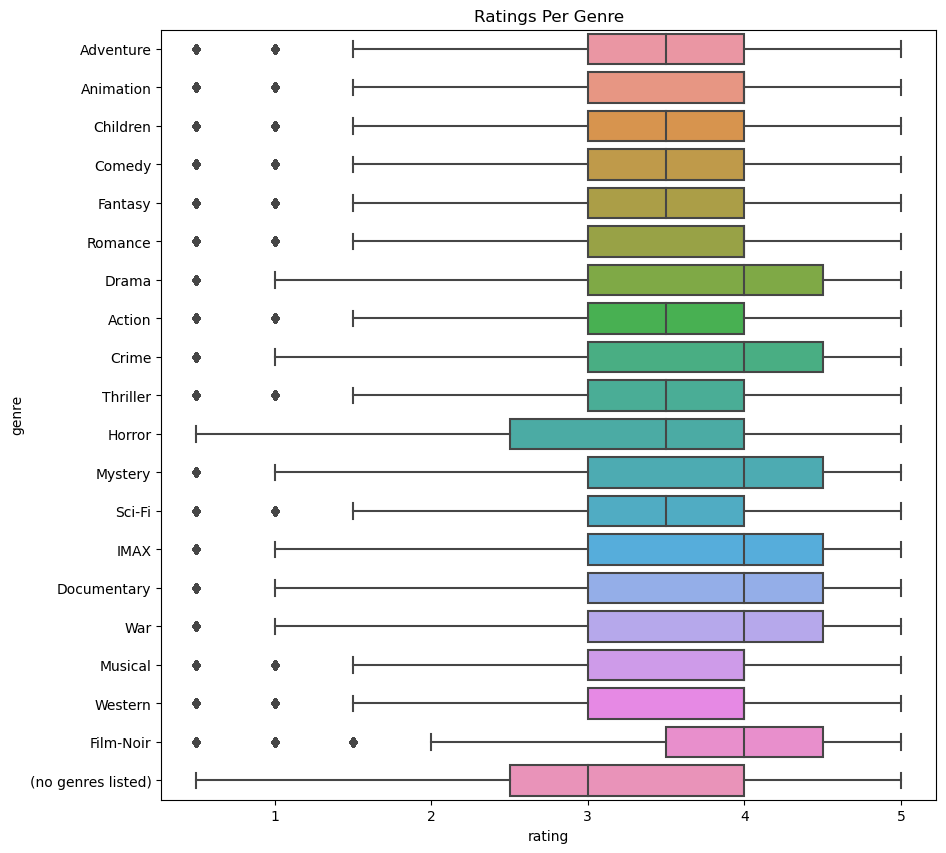

In [5]:
genres_expanded = df.drop('genres', axis=1).join(
    df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('genre')
)

plt.figure(figsize=(10, 10))
sns.boxplot(data=genres_expanded, x='rating', y='genre')
plt.title('Ratings Per Genre')
plt.show()

In [6]:
# Calculate the total count of ratings for each movie title

movieratings_df = df.dropna(axis=0, subset = ['title'])   
rating_indicator = (movieratings_df
                      .groupby(by=['title'])['rating']
                      .count()
                      .reset_index()
                      .rename(columns = {'rating':'CountofRatings'})[['title', 'CountofRatings']])

rating_indicator.head(15)

,title,CountofRatings
0,#chicagoGirl: The Social Network Takes on a Di...,3
1,$ (Dollars) (1971),24
2,$5 a Day (2008),39
3,$9.99 (2008),55
4,$ellebrity (Sellebrity) (2012),2
5,'71 (2014),35
6,'Hellboy': The Seeds of Creation (2004),87
7,"'Human' Factor, The (Human Factor, The) (1975)",2
8,'Neath the Arizona Skies (1934),22
9,'R Xmas (2001),19


In [7]:
rating_indicator.describe()

,CountofRatings
count,26729.000000
mean,748.260803
std,3086.673456
min,1.000000
25%,3.000000
50%,18.000000
75%,205.000000
max,67310.000000


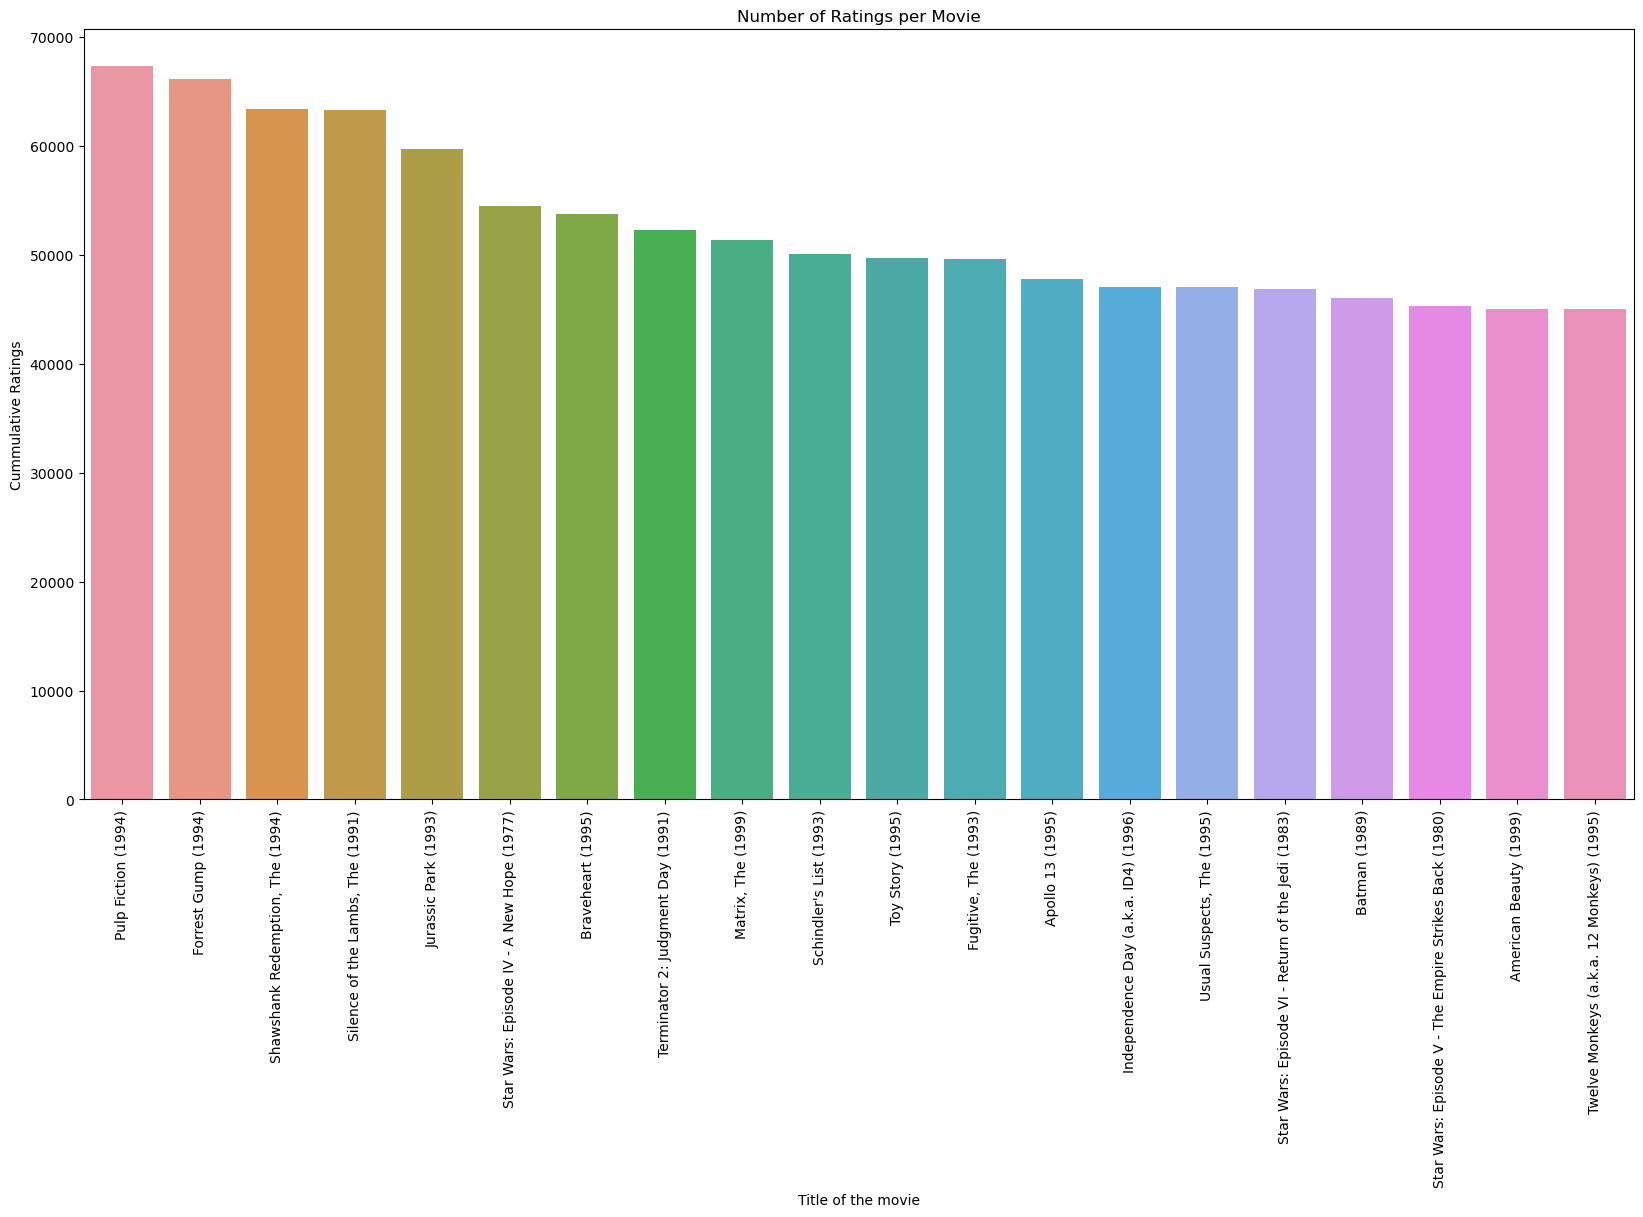

In [8]:
#Calculates the top 20 movie ratings 
top_movies_by_ratings = rating_indicator.sort_values('CountofRatings', ascending=False).head(20)

plt.figure(figsize=(20,10))
sns.barplot(x='title', y='CountofRatings', data=top_movies_by_ratings)
plt.xticks(rotation=90)
plt.title('Number of Ratings per Movie')
plt.xlabel('Title of the movie')
plt.ylabel('Cummulative Ratings')
plt.show()


In [9]:
movieratings_df = movieratings_df.merge(rating_indicator, left_on='title', right_on='title', how='left')
movieratings_df.head()

,movieId,title,genres,userId,rating,CountofRatings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,49695
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,49695
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,49695
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,49695
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,49695


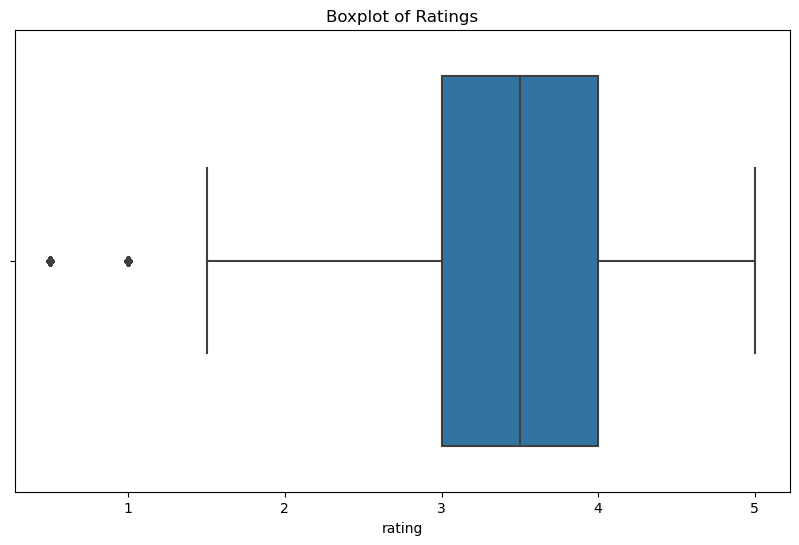

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', data=movieratings_df)
plt.title('Boxplot of Ratings')
plt.show()

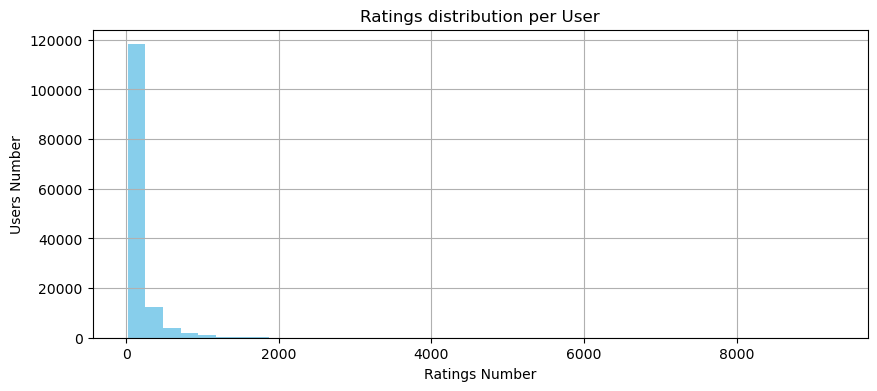

In [11]:
user_rating_count = movieratings_df.groupby('userId')['rating'].count()
plt.figure(figsize=(10,4))
user_rating_count.hist(bins=40, color='skyblue')
plt.title('Ratings distribution per User')
plt.xlabel('Ratings Number')
plt.ylabel('Users Number')
plt.show()

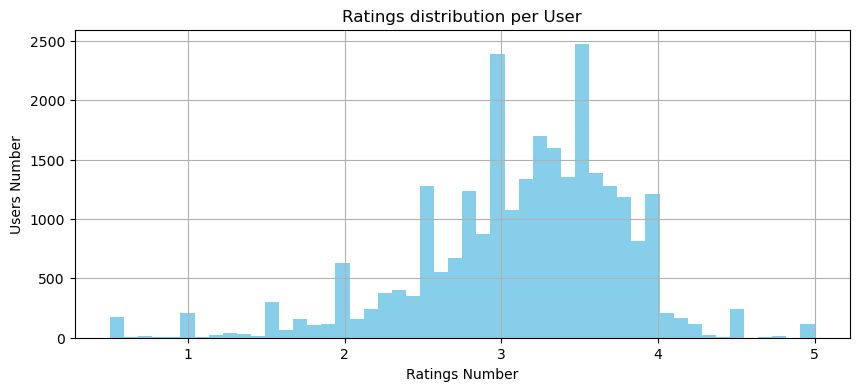

In [12]:
movie_average = movieratings_df.groupby('title')['rating'].mean()
plt.figure(figsize=(10,4))
movie_average.hist(bins=50, color='skyblue')
plt.title('Ratings distribution per User')
plt.xlabel('Ratings Number')
plt.ylabel('Users Number')
plt.show()


In [13]:
barrier_pop = 10000
trending_movies = movieratings_df.query('CountofRatings >= @barrier_pop')
trending_movies.head()

,movieId,title,genres,userId,rating,CountofRatings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,49695
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,49695
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,49695
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,49695
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,49695


In [14]:
trending_movies.shape

(9050403, 6)

In [15]:
set(trending_movies['title'])


{'10 Things I Hate About You (1999)',
 '12 Angry Men (1957)',
 '2001: A Space Odyssey (1968)',
 '28 Days Later (2002)',
 '300 (2007)',
 'A.I. Artificial Intelligence (2001)',
 'Abyss, The (1989)',
 'Ace Ventura: Pet Detective (1994)',
 'Ace Ventura: When Nature Calls (1995)',
 'Addams Family Values (1993)',
 'Adventures of Priscilla, Queen of the Desert, The (1994)',
 'African Queen, The (1951)',
 'Air Force One (1997)',
 'Airplane! (1980)',
 'Aladdin (1992)',
 'Alien (1979)',
 'Alien: Resurrection (1997)',
 'Aliens (1986)',
 'Alien³ (a.k.a. Alien 3) (1992)',
 'Almost Famous (2000)',
 'Amadeus (1984)',
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'American Beauty (1999)',
 'American History X (1998)',
 'American Pie (1999)',
 'American President, The (1995)',
 'Animal House (1978)',
 'Annie Hall (1977)',
 'Antz (1998)',
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Arachnophobia (1990)',
 'Armageddon (1998)',
 'Army of Darkness (1993)',
 'As Good as It Gets (1997)',
 'A

In [16]:
attributes = trending_movies.pivot_table(index='title', columns='userId', values='rating').fillna(0)
attributes.head()

userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0
2001: A Space Odyssey (1968),3.5,5.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28 Days Later (2002),3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5


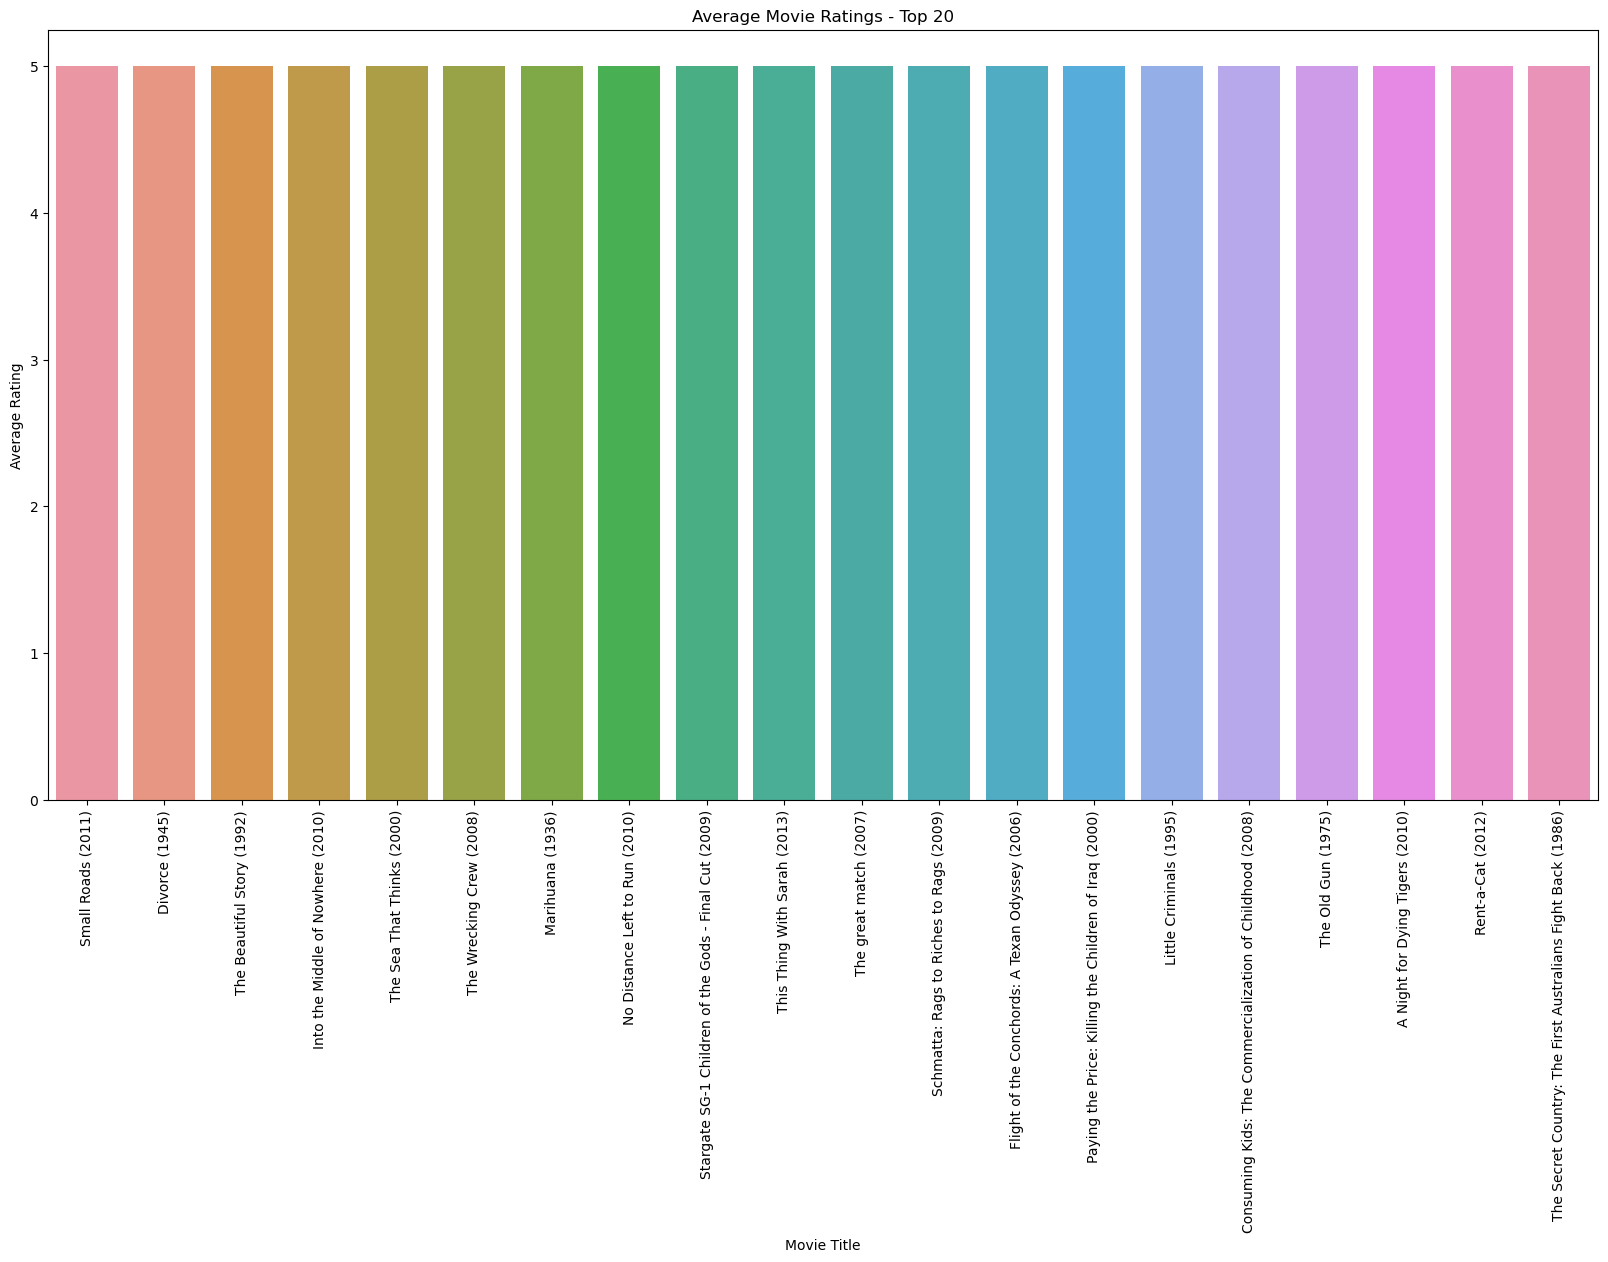

In [17]:
average_ratings = df.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(20,10))
sns.barplot(x=average_ratings.index, y=average_ratings.values)
plt.xticks(rotation=90)
plt.title('Average Movie Ratings - Top 20')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.show()

Algorithm:
    

Data Preparation:
The attributes DataFrame, which contains movies along with their features, is converted into a sparse matrix (attr_matrix). 
This matrix format is computationally efficient for the type of vector operations required by nearest neighbors algorithms.


Model Setup:
A Nearest Neighbors model is initialized using the cosine similarity metric and a brute-force algorithm. 
The cosine similarity measures the cosine of the angle between two vectors (in this case, movie feature vectors), which effectively assesses how similar the movies are in terms of their features. 
A value closer to 1 means very similar, and closer to 0 means less similar.

Model Fitting:
The model is trained (or fitted) on the entire dataset represented by attr_matrix, which prepares it for querying.


Generating Recommendations:
    
When the function generate_recommendations is called with a specific movie index or movie name, the corresponding row from attr_matrix is used as the query vector.
The kneighbors method of the model is then used to find the nearest neighbors to this query vector. This method returns the distances of the nearest neighbors and their indices in the dataset.
The function prints out the titles of the recommended movies along with their similarity scores.

In [18]:
#Given MovieId it, it recommends all similar movies 
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Assuming 'attributes' is a DataFrame where rows are items (e.g., movies) and columns are features of these items.

# Convert DataFrame to sparse matrix format, suitable for efficient computation
attr_matrix = csr_matrix(attributes.values)

# Initialize the Nearest Neighbors model
model = NearestNeighbors(metric="cosine", algorithm="brute")
model.fit(attr_matrix)

def generate_recommendations(search_movie_idx, n_neighbors=10):
    """
    Generates and prints a list of movie recommendations based on the provided index.
    
    Parameters:
    - search_movie_idx: int, the index of the movie for which recommendations are to be generated.
    - n_neighbors: int, the number of neighbors to retrieve (default is 10).
    """
    if search_movie_idx >= 0 and search_movie_idx < len(attributes):
       
        search_query = attr_matrix[search_movie_idx].reshape(1, -1)

        # Perform the nearest neighbor search
        distances, indices = model.kneighbors(search_query, n_neighbors=n_neighbors + 1)

        # Print recommendations
        print(f"Recommendations for '{attributes.index[search_movie_idx]}':\n")
        count = 0
        for i in range(len(distances.flatten())):
            if indices.flatten()[i] == search_movie_idx:
                continue  # Skip the input movie itself
            count += 1
            print(f"{count}: {attributes.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]:.2f}")
            if count == n_neighbors:
                break
    else:
        print("Invalid movie index. Please provide a valid index within the range of the dataset.")


search_movie_idx = 445  # Example index, replace with a valid index as needed
generate_recommendations(search_movie_idx)


Recommendations for 'Waterworld (1995)':

1: Stargate (1994), with distance of 0.40
2: Cliffhanger (1993), with distance of 0.41
3: Batman Forever (1995), with distance of 0.42
4: Die Hard: With a Vengeance (1995), with distance of 0.42
5: True Lies (1994), with distance of 0.42
6: Outbreak (1995), with distance of 0.43
7: Batman (1989), with distance of 0.43
8: Net, The (1995), with distance of 0.45
9: GoldenEye (1995), with distance of 0.45
10: Dances with Wolves (1990), with distance of 0.46


In [19]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

#Given Movie title, it recommends all similar movies 

# Convert DataFrame to sparse matrix format, suitable for efficient computation
attr_matrix = csr_matrix(attributes.values)

# Initialize the Nearest Neighbors model
model = NearestNeighbors(metric="cosine", algorithm="brute")
model.fit(attr_matrix)

# Function to find recommendations based on movie name
def find_recommendations(movie_name, num_recommendations=10):
    if movie_name in attributes.index:
        search_movie_idx = attributes.index.get_loc(movie_name)
        search_query = attr_matrix[search_movie_idx].reshape(1, -1)

        # Perform the nearest neighbor search
        distances, indices = model.kneighbors(search_query, n_neighbors=num_recommendations + 1)

        # Print recommendations
        print(f"Recommendations for '{movie_name}':\n")
        count = 0
        for i in range(0, len(distances.flatten())):
            if indices.flatten()[i] == search_movie_idx:
                continue  
            count += 1
            print(f"{count}: {attributes.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]:.2f}")
            if count == num_recommendations:
                break
    else:
        print("Movie not found. Please check the spelling or try another movie.")


movie_to_search = "Waterworld (1995)"
find_recommendations(movie_to_search)


Recommendations for 'Waterworld (1995)':

1: Stargate (1994), with distance of 0.40
2: Cliffhanger (1993), with distance of 0.41
3: Batman Forever (1995), with distance of 0.42
4: Die Hard: With a Vengeance (1995), with distance of 0.42
5: True Lies (1994), with distance of 0.42
6: Outbreak (1995), with distance of 0.43
7: Batman (1989), with distance of 0.43
8: Net, The (1995), with distance of 0.45
9: GoldenEye (1995), with distance of 0.45
10: Dances with Wolves (1990), with distance of 0.46
